In [4]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

torch.set_default_dtype(torch.double)

Appended 3 sample(s) → tmp.json


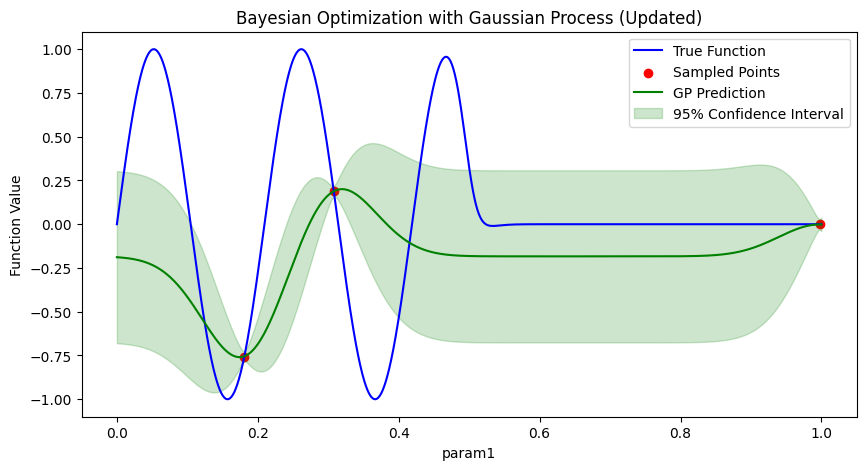

Appended 3 sample(s) → tmp.json


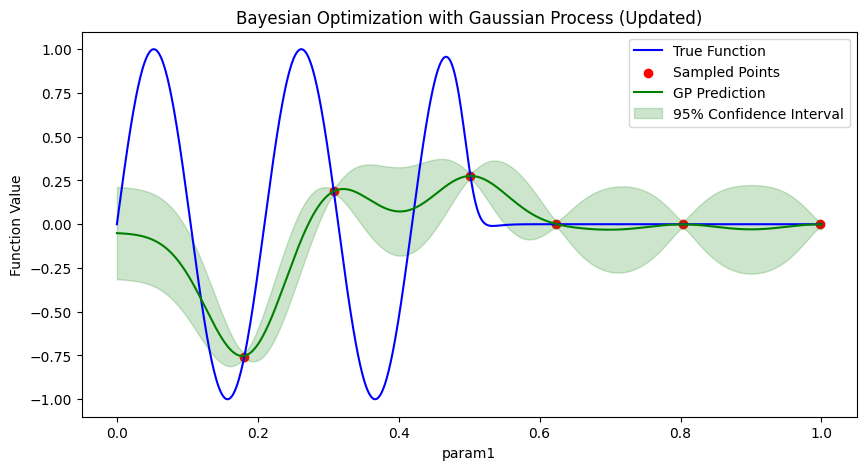

Appended 3 sample(s) → tmp.json


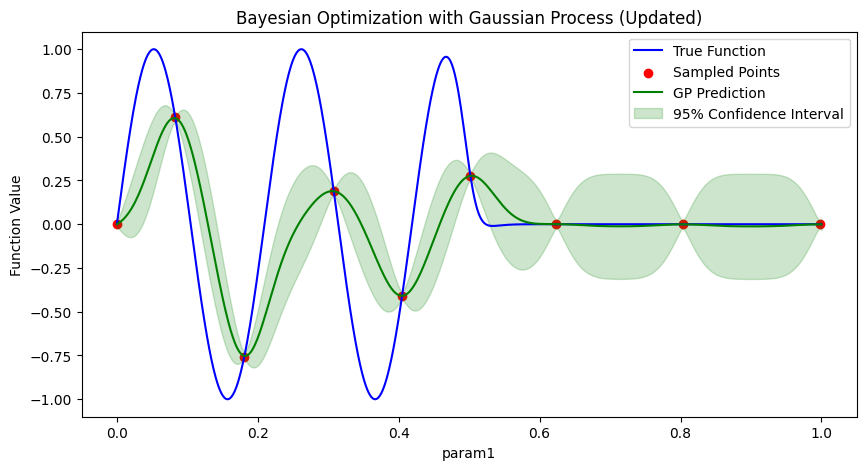

Appended 3 sample(s) → tmp.json


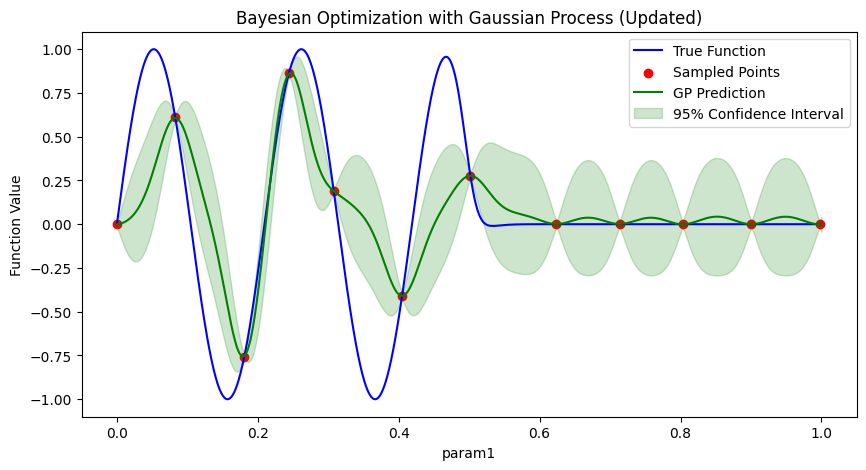

Appended 3 sample(s) → tmp.json


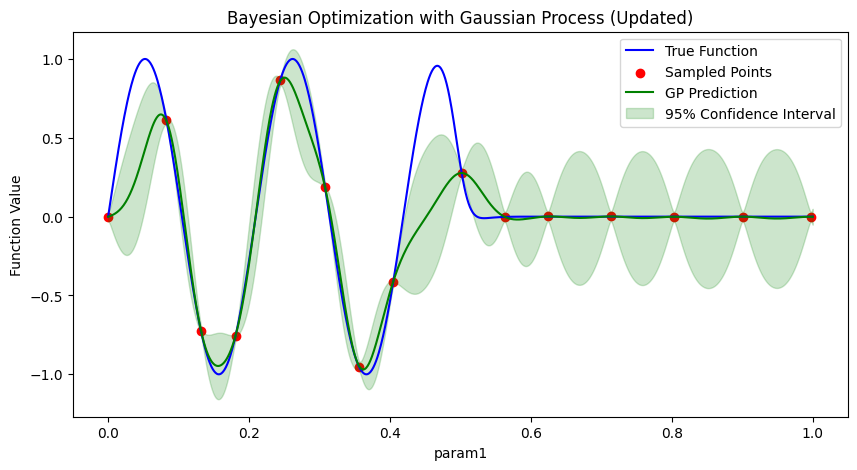

Appended 3 sample(s) → tmp.json


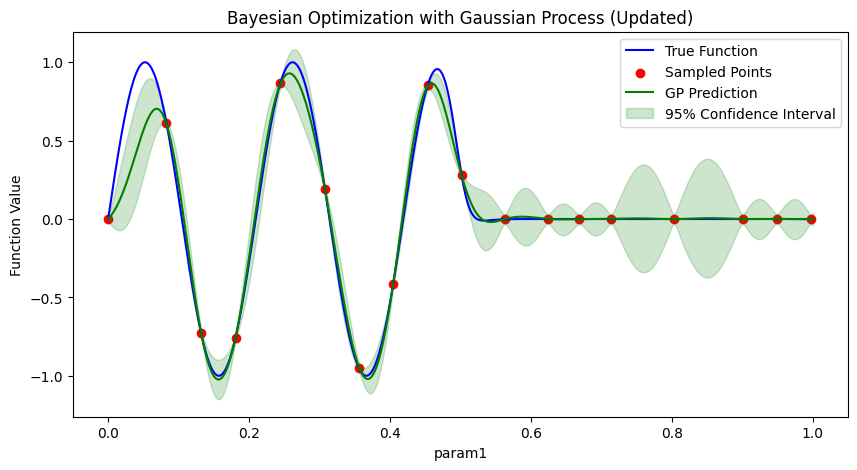

Appended 3 sample(s) → tmp.json


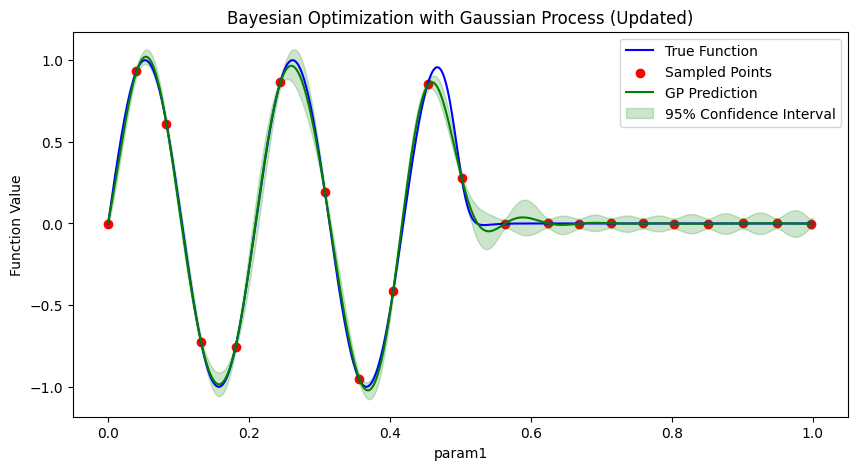

In [5]:
noise = 1e-3

def function(x):
    return np.sin(30*x) / (1 + np.exp(100*(x-0.5)))

def create_json():
    experiment = {
        "parameters": [
            {"name": "x", "type": "range", "bounds": [0.0, 1.0]}
        ],
        "samples": []
    }
    with open("tmp.json", "w") as f:
        json.dump(experiment, f, indent=2)

def delete_json():
    if os.path.exists("tmp.json"):
        os.remove("tmp.json")

def sample(n=1):
    os.system(f"python doe.py tmp.json --samples {n} --noise {noise} --seed 42")
    with open("tmp.json") as f:
        experiment = json.load(f)
    for sample in experiment["samples"]:
        if sample.get("result") is None:
            x = float(sample["x"])
            sample["result"] = function(x) + np.random.normal(0, noise)
    with open("tmp.json", "w") as f:
        json.dump(experiment, f, indent=2)

def plot_gp(x_sample, y_sample):
    x = np.linspace(0, 1, 1000)
    y = function(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label="True Function", color="blue")

    plt.scatter(x_sample, y_sample, label="Sampled Points", color="red")

    X = torch.tensor(x_sample).unsqueeze(-1)
    Y = torch.tensor(y_sample).unsqueeze(-1)
    Yvar = torch.tensor([noise] * len(y_sample)).unsqueeze(-1)

    model = SingleTaskGP(X, Y, Yvar)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    x_gp = torch.linspace(0, 1, 1000).unsqueeze(-1)
    with torch.no_grad():
        output = model(x_gp)
        y_gp = output.mean
        sigma_gp = output.variance.sqrt()
        y_gp, sigma_gp = model.outcome_transform.untransform(y_gp, sigma_gp)
        y_gp, sigma_gp = y_gp.squeeze().numpy(), sigma_gp.squeeze().numpy()

    plt.plot(x, y_gp, label="GP Prediction", color="green")
    plt.fill_between(x, y_gp - 1.96 * sigma_gp, y_gp + 1.96 * sigma_gp, color="green", alpha=0.2, label="95% Confidence Interval")
    plt.xlabel("param1")
    plt.ylabel("Function Value")
    plt.title("Bayesian Optimization with Gaussian Process (Updated)")
    plt.legend()
    plt.show()

def sample_and_plot(n=1):
    sample(n)
    with open("tmp.json") as f:
        experiment = json.load(f)

    x_sample = [s["x"] for s in experiment["samples"]]
    y_sample = [s["result"] for s in experiment["samples"]]
    
    plot_gp(x_sample, y_sample)

create_json()
for _ in range(7):
    sample_and_plot(3)
delete_json()